## Facebook reviews analysis
The goal of this project was to build classification model to predict sentiment of reviews

#### Importing libraries

In [121]:
import pandas as pd
import sklearn
import nltk
from wordcloud import WordCloud
from tqdm import tqdm
import os
from langdetect import detect_langs
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Loading dataset
Dataset contains over 4 millions Facebook reviews from google store from 31 countries. Dataset columns are:
- review_id
- pseudo_author_id
- author_name
- review_text
- review_rating
- review_likes
- author_app_version
- review_timestamp

Dataset was downloaded from Kaggle: https://www.kaggle.com/datasets/bwandowando/facebook-app-google-store-reviews-31-countries

In [123]:
file_size = os.stat('FACEBOOK_REVIEWS.csv').st_size
print(file_size)

679953499


The size of this dataset was close to 700 mb, so it was decided to use only 10% od data in this project.

In [125]:
#df = pd.read_csv('FACEBOOK_REVIEWS.csv', skiprows=lambda i: i > 0 and i % 10 != 0)
#df.head()

In [126]:
#df.to_csv('FACEBOOK_REVIEWS_sample.csv', index = False)

In [127]:
#df = pd.read_csv('FACEBOOK_REVIEWS_sample.csv')
#df.head()

Columns that will be used in project are review_rating and review_text.

#### Droping unnecessary columns

In [130]:
#df = df[['review_text', 'review_rating']]
#df.head()

#### Checking missing values

In [132]:
#df['review_rating'].isna().sum()

In [133]:
#df['review_text'].isna().sum()

In [134]:
#df = df.dropna()
#df['review_text'].isna().sum()

Looking at first rows we can see that column review_text contains reviews in diffrent languages. Because of that first step will be to filter only reviews in English.

#### Filtering Dataset to keep only reviews in English

Example of langdetect library functions

In [138]:
s = 'Hva med chat det haster!!!'
print(detect_langs(s))
print(detect(s))

[da:0.7142830602654058, sv:0.28571674862749463]
da


In [139]:
#languages = []
#for row in tqdm(range(len(df.review_text))):
#    try:
#        languages.append(detect(df.review_text.iloc[row]))
#    except:
#        languages.append(None)
#print(languages)

In [140]:
#df['language'] = languages

In [141]:
#df.head(25)

In [142]:
#df.to_csv('FACEBOOK_REVIEWS_sample_lang.csv', index = False)

In [143]:
df = pd.read_csv('FACEBOOK_REVIEWS_sample_lang.csv')
df.head()

,review_text,review_rating,language
0,Bra app,3,it
1,Hva med chat det haster!!!,4,da
2,機能が限定されているのでちょっと不便。,3,ja
3,Versjon 1.3.1 tapper batteriet raskt. Avinnsta...,2,no
4,Good,5,so


In this project I will focus only on reviews in English.

In [145]:
df['language'].value_counts()

language
en       122352
id        37426
so        33645
ar        25774
pt        19240
ro        16318
af        15273
tl        13716
it         8690
de         8475
ja         7997
sw         6231
pl         5906
ru         5457
et         5232
fr         4558
no         4204
nl         4189
hi         4021
ca         3934
hr         3912
cy         3670
fi         3492
sk         2862
sl         2810
sq         2570
vi         2486
es         2338
lt         2173
tr         2090
bn         2044
sv         2034
da         1748
fa         1606
ur         1472
cs         1445
mr         1437
ne         1359
hu         1336
lv          637
bg          584
uk          477
mk          220
ko          184
ta          163
gu          147
zh-cn        89
th           82
kn           79
ml           69
te           64
pa           47
el           39
he           27
zh-tw        11
Name: count, dtype: int64

<Axes: xlabel='language', ylabel='count'>

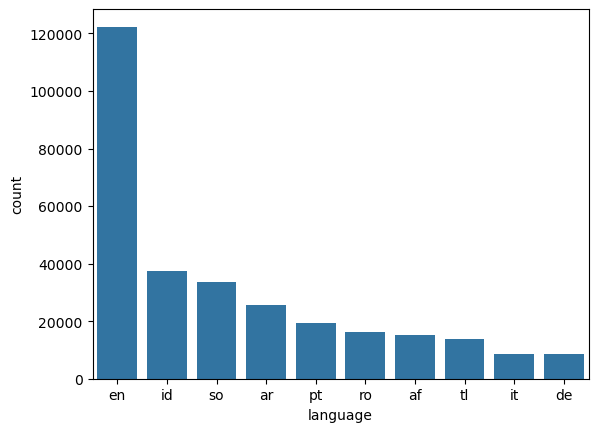

In [146]:
sns.barplot(df['language'].value_counts().head(10))

In [147]:
df.language.isna().sum()

11795

In [148]:
df.shape

(410236, 3)

The results show that detect() function from langdetect library did quite well. It was not able to detect language in less than 3% of cases. Based on the results, it is clear that English is the most common language in reviews.

In [150]:
df = df[df['language'] == 'en']

#### Mapping review_rating into sentiment

In [152]:
df['review_rating'].value_counts()

review_rating
1    64436
5    40805
4     5903
2     5717
3     5491
Name: count, dtype: int64

<Axes: xlabel='review_rating', ylabel='count'>

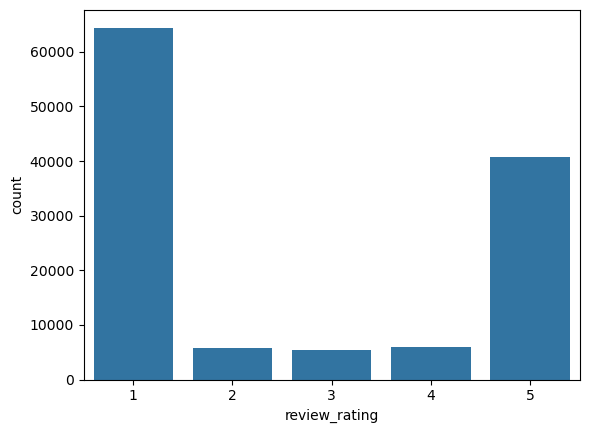

In [153]:
sns.barplot(df['review_rating'].value_counts())

Above graph shows that thera are mostly very bad or very good reviews. Ratings will be divided into 3 categories as follow:
- 1 or 2 - negative
- 3 - neutral
- 4 or 5 -positive
Negative will be represented as 0, neutral as 1 and positive as 2.

In [155]:
def sentiment(x):
    if x <= 2 :
        return 0
    elif x == 3:
        return 1
    else:
        return 2

df['sentiment'] = df['review_rating'].map(sentiment)

In [156]:
df.head(50)

,review_text,review_rating,language,sentiment
7,"What this app needs, is a chat!",2,en,0
9,"Nice when it worked.. now will not open, reins...",5,en,2
10,Need SD support.,2,en,0
16,App to SD plz!,3,en,1
21,Really slow,1,en,0
29,"Working veryn nicely, but missing some crucial...",4,en,2
74,Unable to access Friend. Got error message eve...,1,en,0
85,Not working on xoom any more after update.,1,en,0
87,There's a lot of bugs in the new version.FIX I...,1,en,0
101,It would be nice to see everything on own site...,2,en,0


#### Function to showing results

In [158]:
def show_results(y_train, y_pred_train, y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    print('Accuracy score on training data:', accuracy_score(y_train, y_pred_train))
    print('Accuracy score on test data:', accuracy_score(y_test, y_pred_test))
    labels = ('Negative', 'Neutral', 'Positive') if len(y_test.unique()) == 3 else ('Negative', 'Positive')
    disp = ConfusionMatrixDisplay(cm, display_labels = labels)
    disp.plot()
    plt.show()

#### Function to split data, train model and show results

In [160]:
def split_train_score(X, vect, y=df['sentiment'].copy()):
    X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = 77, stratify = y)
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', y_test.shape, '\n')
    print('y_train value counts:\n ', y_train.value_counts())
    print('y_test value counts:\n ', y_test.value_counts())
    
    model = LogisticRegression(max_iter = 200)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    show_results(y_train, y_pred_train, y_test, y_pred_test)

#### Function to generate word cloud

In [162]:
def generate_word_cloud(X, vect):
    X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
    freq_dict = {}
    print(X_df.sum().sort_values(ascending = False))
    for i, x in X_df.sum().sort_values(ascending = False).items():
        freq_dict[i] = x
    cloud = WordCloud().generate_from_frequencies(freq_dict)
    plt.imshow(cloud, interpolation = 'bilinear')
    plt.show()

#### Bag of Words with CountVectorizer() function

In [164]:
vect = CountVectorizer(max_features = 1000)
vect.fit(df['review_text'])
X = vect.transform(df['review_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8294663928648052
Accuracy score on test data: 0.8247313146173021


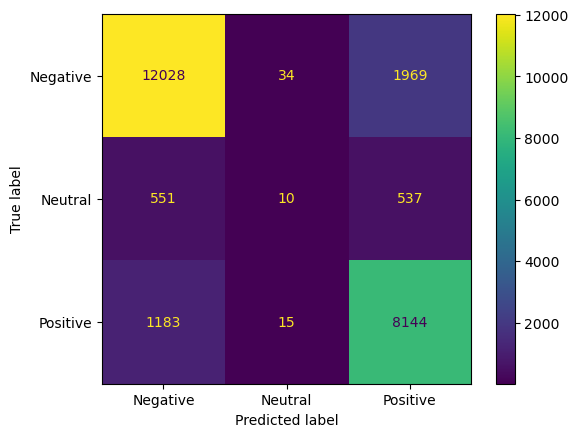

the         39716
and         38168
to          37732
it          33070
app         32144
            ...  
thoughts      137
1st           137
program       137
huge          136
process       135
Length: 1000, dtype: int64


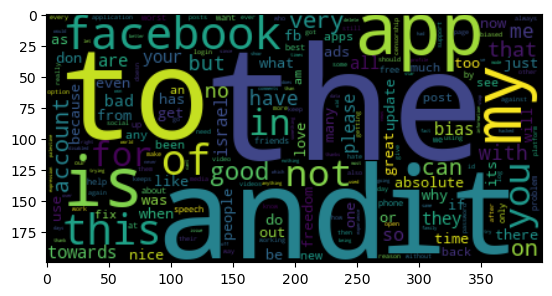

In [165]:
split_train_score(X, vect)
generate_word_cloud(X, vect)

#### Bag of Words with CountVectorizer() function with max_features = 3000

In [167]:
vect_maxf_3k = CountVectorizer(max_features = 3000)
vect_maxf_3k.fit(df['review_text'])
X_maxf_3k = vect_maxf_3k.transform(df['review_text'])

X_train shape:  (97881, 3000)
y_train shape:  (97881,)
X_test shape:  (24471, 3000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8451793504357332
Accuracy score on test data: 0.8298802664378243


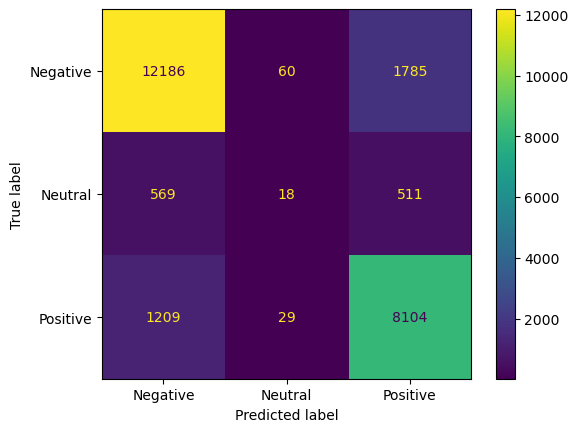

the           39716
and           38168
to            37732
it            33070
app           32144
              ...  
tyranny          24
tagging          24
automated        24
halp             24
supposedly       24
Length: 3000, dtype: int64


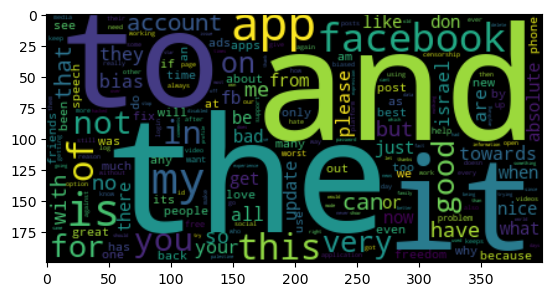

In [168]:
split_train_score(X_maxf_3k, vect_maxf_3k)
generate_word_cloud(X_maxf_3k, vect_maxf_3k)

#### Bag of Words with CountVectorizer() function, ngrams = (1, 2)

In [170]:
vect_ng12 = CountVectorizer(max_features = 1000, ngram_range = (1, 2))
vect_ng12.fit(df['review_text'])
X_ng12 = vect_ng12.transform(df['review_text'])

In [171]:
X_ng12_df = pd.DataFrame(X_ng12.toarray(), columns=vect_ng12.get_feature_names_out())

In [172]:
n_unigrams = sum([1 for x in X_ng12_df.sum().index.to_list() if len(x.split()) == 1])
n_bigrams = sum([1 for x in X_ng12_df.sum().index.to_list() if len(x.split()) == 2])
print('Number of unigrams: ', n_unigrams)
print('Number of bigrams: ', n_bigrams)

Number of unigrams:  621
Number of bigrams:  379


<Axes: >

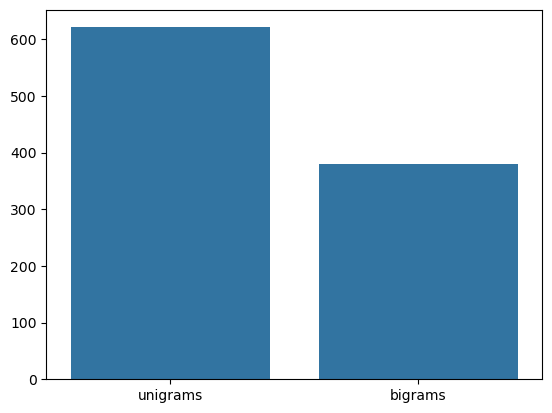

In [173]:
sns.barplot(x=['unigrams', 'bigrams'], y=[n_unigrams, n_bigrams])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.826462745578815
Accuracy score on test data: 0.8224837562829471


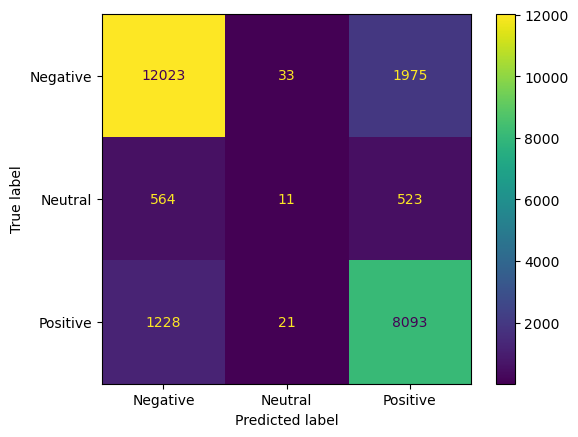

the              39716
and              38168
to               37732
it               33070
app              32144
                 ...  
call               276
pro                275
it but             275
what happened      275
about the          274
Length: 1000, dtype: int64


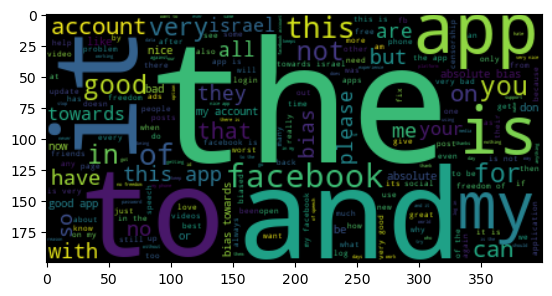

In [174]:
split_train_score(X_ng12, vect_ng12)
generate_word_cloud(X_ng12, vect_ng12)

#### Bag of Words with CountVectorizer() function with removed stopwords

In [176]:
my_stop_words = list(ENGLISH_STOP_WORDS)
vect_no_sw = CountVectorizer(max_features = 1000, stop_words = my_stop_words)
vect_no_sw.fit(df['review_text'])
X_no_sw = vect_no_sw.transform(df['review_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8210275742994044
Accuracy score on test data: 0.8161088635527768


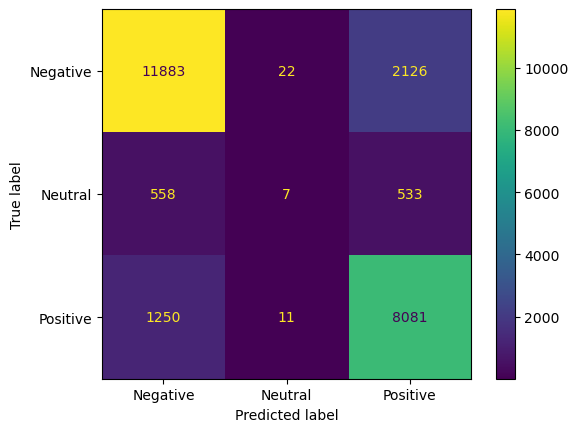

app          32144
facebook     24897
good         14056
account      11360
bias          6426
             ...  
countries      104
answer         104
didnt          104
dangerous      104
unusable       104
Length: 1000, dtype: int64


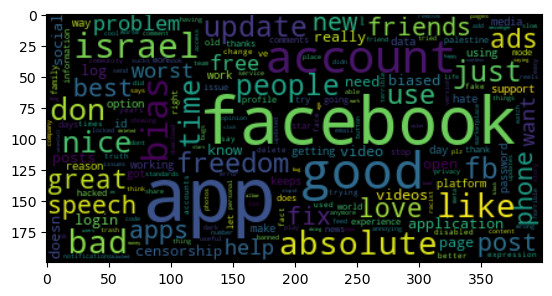

In [177]:
split_train_score(X_no_sw, vect_no_sw)
generate_word_cloud(X_no_sw, vect_no_sw)

#### Bag of Words with CountVectorizer() function, Binary Classification

In [179]:
df_bi = df[df['sentiment'] != 1]
df_bi.head(10)

,review_text,review_rating,language,sentiment
7,"What this app needs, is a chat!",2,en,0
9,"Nice when it worked.. now will not open, reins...",5,en,2
10,Need SD support.,2,en,0
21,Really slow,1,en,0
29,"Working veryn nicely, but missing some crucial...",4,en,2
74,Unable to access Friend. Got error message eve...,1,en,0
85,Not working on xoom any more after update.,1,en,0
87,There's a lot of bugs in the new version.FIX I...,1,en,0
101,It would be nice to see everything on own site...,2,en,0
129,"Its ok only, hard to change profil pic .other ...",4,en,2


In [180]:
vect_bi = CountVectorizer(max_features = 1000)
vect_bi.fit(df_bi['review_text'])
X_bi = vect_bi.transform(df_bi['review_text'])

X_train shape:  (93488, 1000)
y_train shape:  (93488,)
X_test shape:  (23373, 1000)
y_test shape:  (23373,) 

y_train value counts:
  sentiment
0    56122
2    37366
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
Name: count, dtype: int64
Accuracy score on training data: 0.8690420160876262
Accuracy score on test data: 0.8646729131904334


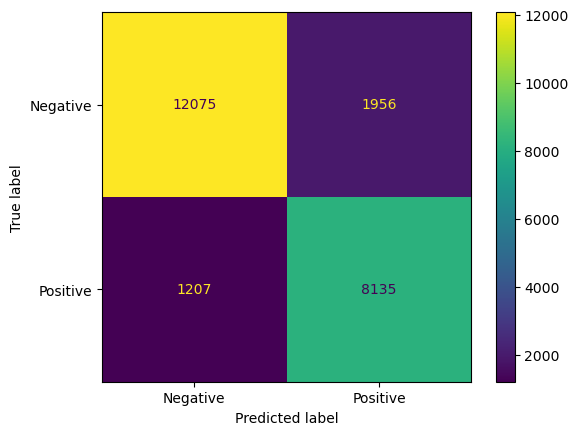

the              37482
and              36602
to               35518
it               30949
app              30787
                 ...  
product            130
opened             130
women              130
crash              129
disappointing      129
Length: 1000, dtype: int64


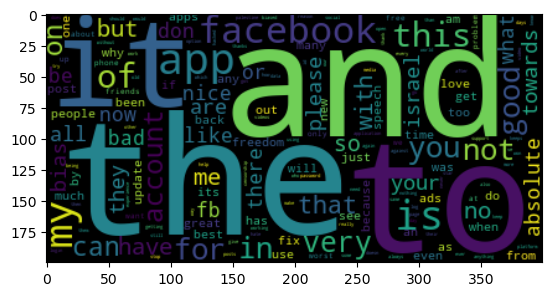

In [181]:
split_train_score(X_bi, vect_bi, df_bi['sentiment'].copy())
generate_word_cloud(X_bi, vect_bi)

#### TfidfVectorizer() function

In [183]:
vect_tfidf = TfidfVectorizer(max_features = 1000)
vect_tfidf.fit(df['review_text'])
X_tfidf = vect_tfidf.transform(df['review_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8319796487571643
Accuracy score on test data: 0.8293490253769769


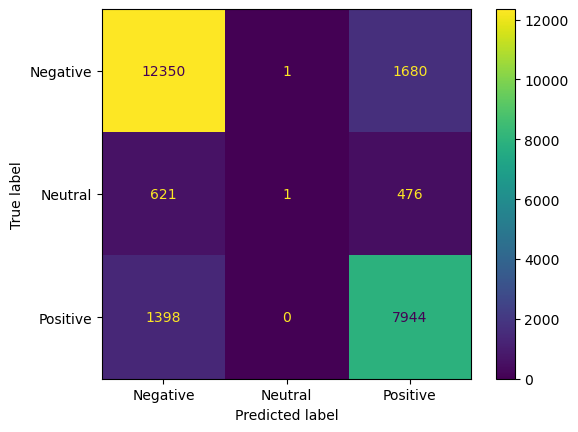

app            8533.694688
good           6619.420640
it             5076.643254
the            5001.591602
is             4861.967478
                  ...     
wouldn           38.180109
permanently      35.865967
mail             35.720753
couple           35.285003
however          33.026669
Length: 1000, dtype: float64


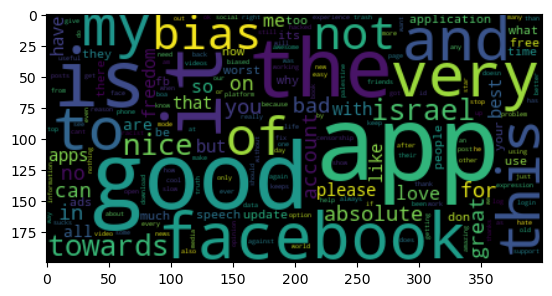

In [184]:
split_train_score(X_tfidf, vect_tfidf)
generate_word_cloud(X_tfidf, vect_tfidf)

#### TfidfVectorizer() function, ngrams = (1, 2)

In [186]:
vect_tfidf_ng12 = TfidfVectorizer(max_features = 1000, ngram_range = (1,2))
vect_tfidf_ng12.fit(df['review_text'])
X_tfidf_ng12 = vect_tfidf_ng12.transform(df['review_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8288942695722357
Accuracy score on test data: 0.8257120673450207


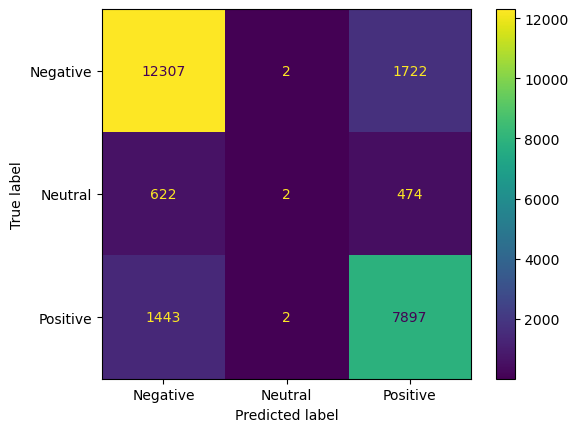

app         6870.104229
good        5062.415909
the         4516.978408
it          4452.606987
and         4295.209737
               ...     
it but        65.180680
get the       64.188027
ve been       62.959874
and will      62.879661
and when      57.885319
Length: 1000, dtype: float64


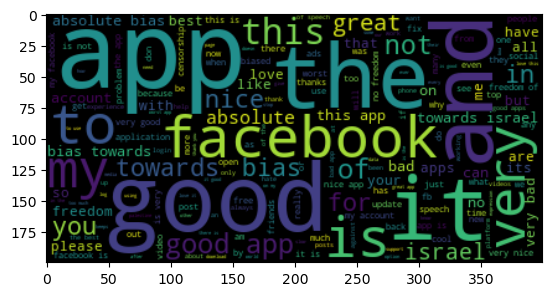

In [187]:
split_train_score(X_tfidf_ng12, vect_tfidf_ng12)
generate_word_cloud(X_tfidf_ng12, vect_tfidf_ng12)

#### TfidfVectorizer() function with removed stopwords

In [189]:
my_stop_words = list(ENGLISH_STOP_WORDS)
vect_tfidf_no_sw = TfidfVectorizer(max_features = 1000, stop_words = my_stop_words)
vect_tfidf_no_sw.fit(df['review_text'])
X_tfidf_no_sw = vect_tfidf_no_sw.transform(df['review_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8232343355707441
Accuracy score on test data: 0.819459768705815


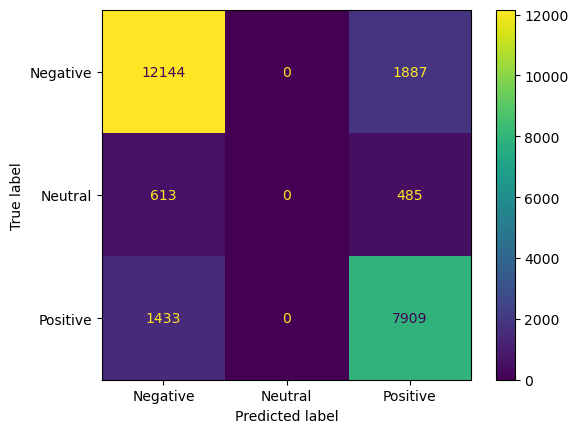

app         10155.007999
good         7823.465791
facebook     5719.767515
bias         3327.957524
nice         3113.096395
                ...     
shouldn        38.298528
cache          38.094149
linked         37.737657
confirm        37.706466
answer         35.940589
Length: 1000, dtype: float64


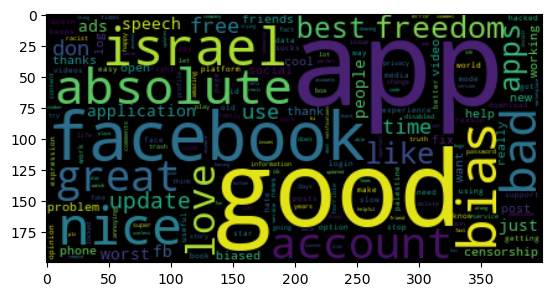

In [190]:
split_train_score(X_tfidf_no_sw, vect_tfidf_no_sw)
generate_word_cloud(X_tfidf_no_sw, vect_tfidf_no_sw)

#### Text investigation

In [192]:
pd.set_option('display.max_colwidth', 500)
df.head(20)

,review_text,review_rating,language,sentiment
7,"What this app needs, is a chat!",2,en,0
9,"Nice when it worked.. now will not open, reinstall, or uninstall completely.",5,en,2
10,Need SD support.,2,en,0
16,App to SD plz!,3,en,1
21,Really slow,1,en,0
29,"Working veryn nicely, but missing some crucial features like how you rotate an uploaded picture???",4,en,2
74,Unable to access Friend. Got error message everytime.,1,en,0
85,Not working on xoom any more after update.,1,en,0
87,There's a lot of bugs in the new version.FIX IT PLZ!!!,1,en,0
101,"It would be nice to see everything on own sites, not only my own updates",2,en,0


In [193]:
print('Liczba recenzji składająca się z 1 słowa:', df[df['review_text'].str.split().apply(len) <=1].shape[0])
print('Liczba recenzji składająca się z maks. 2 słów:', df[df['review_text'].str.split().apply(len) <=2].shape[0])

print('Liczba recenzji składająca się z maks. 3 znaków:', df[df['review_text'].str.len() <=3].shape[0])
print('Liczba recenzji składająca się z maks. 5 znaków:', df[df['review_text'].str.len() <=5].shape[0])

vect = CountVectorizer(max_features = 1000)
vect.fit(df['review_text'])
X = vect.transform(df['review_text'])
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
print('Liczba recenzji, która nie ma żadnej cechy w reprezentacji CountVectorizer():', X_df[X_df.sum(axis = 1) == 0].shape[0])

vect = CountVectorizer(max_features = 1000, stop_words = list(ENGLISH_STOP_WORDS))
vect.fit(df['review_text'])
X = vect.transform(df['review_text'])
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
print('Liczba recenzji, która nie ma żadnej cechy w reprezentacji CountVectorizer() po usunięciu stop_words:', X_df[X_df.sum(axis = 1) == 0].shape[0])

Liczba recenzji składająca się z 1 słowa: 6560
Liczba recenzji składająca się z maks. 2 słów: 21848
Liczba recenzji składająca się z maks. 3 znaków: 1510
Liczba recenzji składająca się z maks. 5 znaków: 4296
Liczba recenzji, która nie ma żadnej cechy w reprezentacji CountVectorizer(): 4284
Liczba recenzji, która nie ma żadnej cechy w reprezentacji CountVectorizer() po usunięciu stop_words: 7938


#### TfidfVectorizer() function for long reviews

In [195]:
df_long = df[df['review_text'].str.len() >20]
df_long.shape

(83615, 4)

In [196]:
vect_long = TfidfVectorizer(max_features = 1000)
vect_long.fit(df_long['review_text'])
X_long = vect_long.transform(df_long['review_text'])

X_train shape:  (66892, 1000)
y_train shape:  (66892,)
X_test shape:  (16723, 1000)
y_test shape:  (16723,) 

y_train value counts:
  sentiment
0    46351
2    17360
1     3181
Name: count, dtype: int64
y_test value counts:
  sentiment
0    11588
2     4340
1      795
Name: count, dtype: int64
Accuracy score on training data: 0.8362135980386294
Accuracy score on test data: 0.8323267356335585


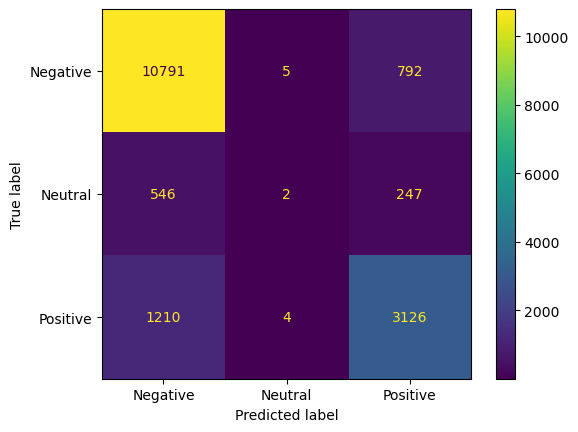

the         4139.976142
and         3954.516700
app         3888.742293
to          3816.841680
is          3806.423186
               ...     
remember      35.084348
couple        35.013170
however       33.580225
asked         32.427689
linked        31.102706
Length: 1000, dtype: float64


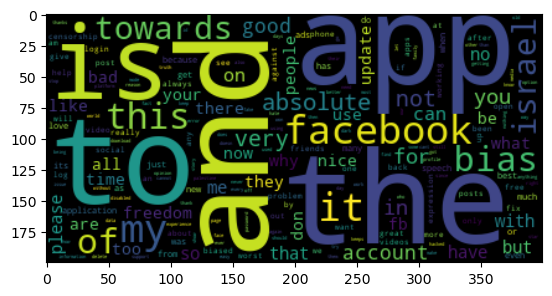

In [197]:
split_train_score(X_long, vect_long, df_long['sentiment'].copy())
generate_word_cloud(X_long, vect_long)

#### TfidfVectorizer() function - removed non alphabetic characters

In [199]:
df.head(50)

,review_text,review_rating,language,sentiment
7,"What this app needs, is a chat!",2,en,0
9,"Nice when it worked.. now will not open, reinstall, or uninstall completely.",5,en,2
10,Need SD support.,2,en,0
16,App to SD plz!,3,en,1
21,Really slow,1,en,0
29,"Working veryn nicely, but missing some crucial features like how you rotate an uploaded picture???",4,en,2
74,Unable to access Friend. Got error message everytime.,1,en,0
85,Not working on xoom any more after update.,1,en,0
87,There's a lot of bugs in the new version.FIX IT PLZ!!!,1,en,0
101,"It would be nice to see everything on own sites, not only my own updates",2,en,0


In [200]:
df['clean_text'] = df['review_text'].str.replace(r'[^a-zA-Z ]', '', regex=True).str.lower()

In [201]:
df.head()

,review_text,review_rating,language,sentiment,clean_text
7,"What this app needs, is a chat!",2,en,0,what this app needs is a chat
9,"Nice when it worked.. now will not open, reinstall, or uninstall completely.",5,en,2,nice when it worked now will not open reinstall or uninstall completely
10,Need SD support.,2,en,0,need sd support
16,App to SD plz!,3,en,1,app to sd plz
21,Really slow,1,en,0,really slow


In [202]:
vect_alpha = TfidfVectorizer(max_features = 1000)
vect_alpha.fit(df['clean_text'])
X_alpha = vect_alpha.transform(df['review_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8301815469805172
Accuracy score on test data: 0.8273466552245515


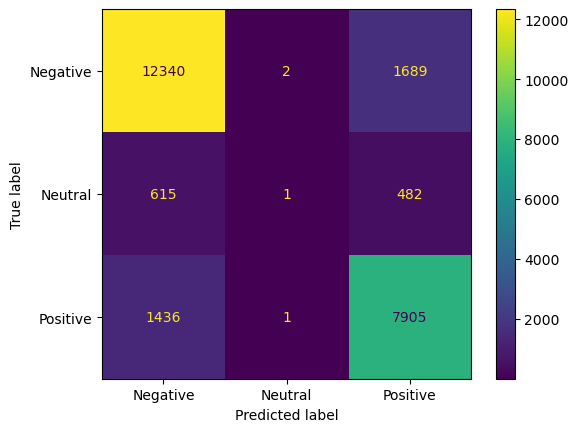

app        8569.383880
good       6629.698045
it         5513.300822
the        5021.627198
is         4861.461266
              ...     
wasnt         4.522287
couldnt       4.271610
arent         3.683922
wouldnt       3.581092
theyre        2.905812
Length: 1000, dtype: float64


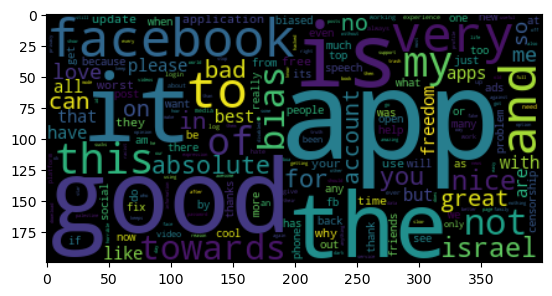

In [203]:
split_train_score(X_alpha, vect_alpha)
generate_word_cloud(X_alpha, vect_alpha)

#### TfidfVectorizer() function with Stemming

In [205]:
porter = PorterStemmer()
def stemming(text):
    words = word_tokenize(text)
    return ' '.join([porter.stem(word) for word in words])
df['stemmed_text'] = df['clean_text'].apply(stemming)

In [206]:
df.head(15)

,review_text,review_rating,language,sentiment,clean_text,stemmed_text
7,"What this app needs, is a chat!",2,en,0,what this app needs is a chat,what thi app need is a chat
9,"Nice when it worked.. now will not open, reinstall, or uninstall completely.",5,en,2,nice when it worked now will not open reinstall or uninstall completely,nice when it work now will not open reinstal or uninstal complet
10,Need SD support.,2,en,0,need sd support,need sd support
16,App to SD plz!,3,en,1,app to sd plz,app to sd plz
21,Really slow,1,en,0,really slow,realli slow
29,"Working veryn nicely, but missing some crucial features like how you rotate an uploaded picture???",4,en,2,working veryn nicely but missing some crucial features like how you rotate an uploaded picture,work veryn nice but miss some crucial featur like how you rotat an upload pictur
74,Unable to access Friend. Got error message everytime.,1,en,0,unable to access friend got error message everytime,unabl to access friend got error messag everytim
85,Not working on xoom any more after update.,1,en,0,not working on xoom any more after update,not work on xoom ani more after updat
87,There's a lot of bugs in the new version.FIX IT PLZ!!!,1,en,0,theres a lot of bugs in the new versionfix it plz,there a lot of bug in the new versionfix it plz
101,"It would be nice to see everything on own sites, not only my own updates",2,en,0,it would be nice to see everything on own sites not only my own updates,it would be nice to see everyth on own site not onli my own updat


In [207]:
vect_stem = TfidfVectorizer(max_features = 1000)
vect_stem.fit(df['stemmed_text'])
X_stem = vect_stem.transform(df['stemmed_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8368937791808421
Accuracy score on test data: 0.8355604593191941


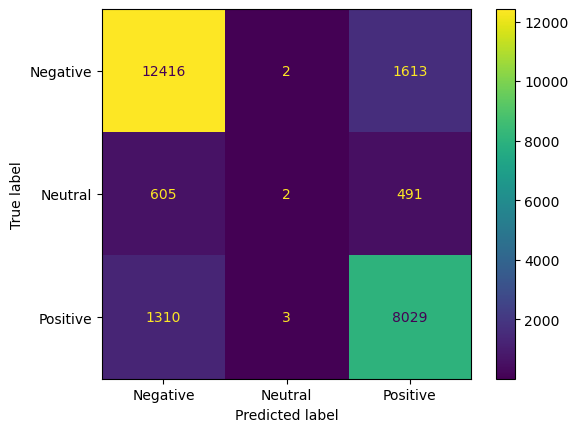

app       9126.013914
good      6811.602190
it        5551.550904
the       4888.490717
is        4803.699931
             ...     
final       31.817671
anyway      31.249537
howev       31.179152
appar       30.865675
decis       29.316737
Length: 1000, dtype: float64


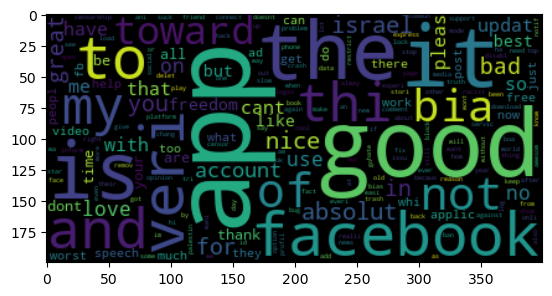

In [208]:
split_train_score(X_stem, vect_stem)
generate_word_cloud(X_stem, vect_stem)

#### TfidfVectorizer() function with Lemmatization

In [210]:
WNlemma = WordNetLemmatizer()
def lemmatizing(text):
    words = word_tokenize(text)
    return ' '.join([WNlemma.lemmatize(word) for word in words])
df['lemmatized_text'] = df['clean_text'].apply(lemmatizing)

In [211]:
df.head(15)

,review_text,review_rating,language,sentiment,clean_text,stemmed_text,lemmatized_text
7,"What this app needs, is a chat!",2,en,0,what this app needs is a chat,what thi app need is a chat,what this app need is a chat
9,"Nice when it worked.. now will not open, reinstall, or uninstall completely.",5,en,2,nice when it worked now will not open reinstall or uninstall completely,nice when it work now will not open reinstal or uninstal complet,nice when it worked now will not open reinstall or uninstall completely
10,Need SD support.,2,en,0,need sd support,need sd support,need sd support
16,App to SD plz!,3,en,1,app to sd plz,app to sd plz,app to sd plz
21,Really slow,1,en,0,really slow,realli slow,really slow
29,"Working veryn nicely, but missing some crucial features like how you rotate an uploaded picture???",4,en,2,working veryn nicely but missing some crucial features like how you rotate an uploaded picture,work veryn nice but miss some crucial featur like how you rotat an upload pictur,working veryn nicely but missing some crucial feature like how you rotate an uploaded picture
74,Unable to access Friend. Got error message everytime.,1,en,0,unable to access friend got error message everytime,unabl to access friend got error messag everytim,unable to access friend got error message everytime
85,Not working on xoom any more after update.,1,en,0,not working on xoom any more after update,not work on xoom ani more after updat,not working on xoom any more after update
87,There's a lot of bugs in the new version.FIX IT PLZ!!!,1,en,0,theres a lot of bugs in the new versionfix it plz,there a lot of bug in the new versionfix it plz,there a lot of bug in the new versionfix it plz
101,"It would be nice to see everything on own sites, not only my own updates",2,en,0,it would be nice to see everything on own sites not only my own updates,it would be nice to see everyth on own site not onli my own updat,it would be nice to see everything on own site not only my own update


In [212]:
vect_lem = TfidfVectorizer(max_features = 1000)
vect_lem.fit(df['lemmatized_text'])
X_lem = vect_lem.transform(df['lemmatized_text'])

X_train shape:  (97881, 1000)
y_train shape:  (97881,)
X_test shape:  (24471, 1000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8337879670211787
Accuracy score on test data: 0.8312696661354256


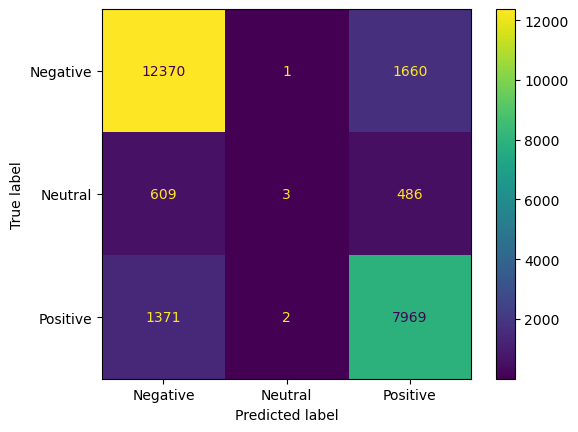

app        8467.193550
good       6644.082592
it         5598.502760
the        4967.257660
is         4854.189858
              ...     
appeal       33.906671
asked        31.816629
actual       31.770308
however      31.745803
linked       30.275655
Length: 1000, dtype: float64


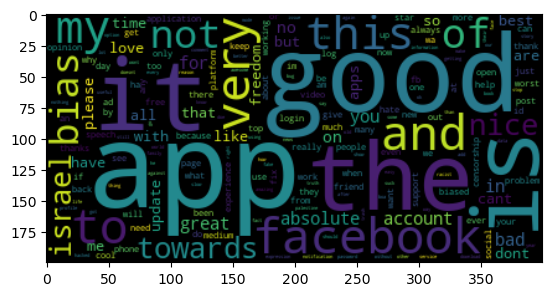

In [213]:
split_train_score(X_lem, vect_lem)
generate_word_cloud(X_lem, vect_lem)

#### TfidfVectorizer() function max_features = 3000 with stemming

In [215]:
vect_tfidf_stem = TfidfVectorizer(max_features = 3000)
vect_tfidf_stem.fit(df['stemmed_text'])
X_tfidf_stem = vect_tfidf_stem.transform(df['stemmed_text'])

X_train shape:  (97881, 3000)
y_train shape:  (97881,)
X_test shape:  (24471, 3000)
y_test shape:  (24471,) 

y_train value counts:
  sentiment
0    56122
2    37366
1     4393
Name: count, dtype: int64
y_test value counts:
  sentiment
0    14031
2     9342
1     1098
Name: count, dtype: int64
Accuracy score on training data: 0.8476721733533576
Accuracy score on test data: 0.8400964406848923


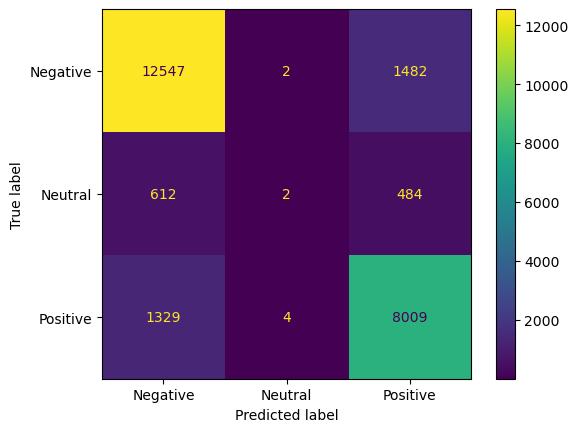

app        8548.306390
good       6609.272363
it         5197.361276
the        4468.610797
is         4440.456029
              ...     
ei            2.637477
receipt       2.387855
namast        2.026550
falo          1.707309
gora          1.360900
Length: 3000, dtype: float64


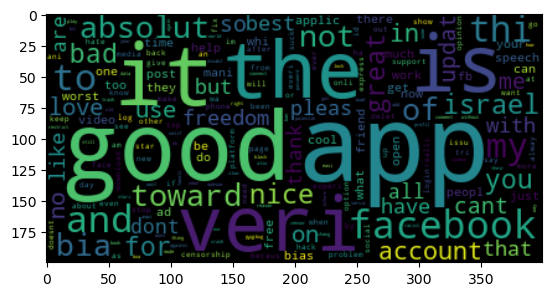

In [216]:
split_train_score(X_tfidf_stem, vect_tfidf_stem)
generate_word_cloud(X_tfidf_stem, vect_tfidf_stem)